# Social Network Protected Search

As mentioned in the accompanying essay, there is a significant amount of research being done in order to understand useful applications of differential privacy algorithms. One such example is social network analysis to find "target" nodes. We use an extreme example of identifying terrorists in social network. While the original researchers who developed this model used IMDB and Publishing data, we replicate their methodology in something more relateable to the example, Facebook friend data.


#### Data: 
Facebook Social Network Data from https://snap.stanford.edu/data/egonets-Facebook.html

#### Concept Attribution: 
We base our functions and methodology on those described by Kearns et al. [1] in their work "Private Algorithms for the Protected in Social Network Search". Proofs for the differential privacy guarantees of their functions are available in their paper.

#### [Process](#first_cell)

**Cost Assumptions:**
In searching for "target" nodes in a dataset, we consider three assumptions of those looking for answers:
- (A) The investigator wants to find as many target nodes as possible. There is no privacy cost to investigating a target node due to the context.
- (B) It costs money to investigate every single node, so search should be targeted
- (C) It is better to investigate as few "non-target" or "protected" nodes as possible

**Workflow:**
- (1) Data Processing: gather and visualize network
- (2) Infection: Encode certain nodes (people) as terrorists through a cascade "infection" process, similar to modeling contagion
- (3) Building: Follow Kearns et al. methodology for private search on a dataset that is different than the ones they use.
- (4) Testing: Assess how many target nodes (in our example, terrorists) are correctly identify, considering Assumptions A-C (above)

[1] Kearns, Michael, et al. "Private algorithms for the protected in social network search." Proceedings of the National Academy of Sciences 113.4 (2016): 913-918. http://www.pnas.org/content/113/4/913.short


In [9]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import tempfile
import os
import sys
%matplotlib inline
import random
import scipy.stats

In [3]:
import networkx as nx
#import community

## (1) Data Processing: Social Network Initial Visualization

Name: 
Type: Graph
Number of nodes: 1177
Number of edges: 2973
Average degree:   5.0518


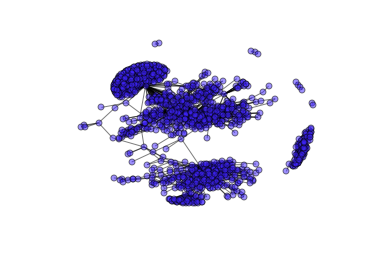

In [196]:
##### Data Separation #####
## Method: 
##       We take relationships that have a weight > 4
##       in order to sparsify the data, see Appendix for methodology

G_fb_w = nx.read_weighted_edgelist("facebook_combined_first10000w.txt")
df_over_n = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] >4 ]
df_under_n = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] <= 4]

network = nx.Graph()
network.add_edges_from(df_over_n)
print nx.info(network)
spring_pos_w = nx.spring_layout(network)
plt.axis("off")
nx.draw_networkx(network, pos = spring_pos_w, with_labels = False, node_size = 35, node_color="#3f24ff",alpha=0.5,linewidths=None)


## (2) Infection: Synthetically Designate Certain Nodes as "infected" (terrorist)

This is a method of "infecting" a network, which is to say that the data do not have any predefined markers of "infected" or "uninfected" and the infected nodes will be assigned synthetically using the "independent cascades" algorithm [2]. See Appendix A for testing of python implementation [3]. 

[2] David Kempe, Jon Kleinberg, and Eva Tardos. Maximizing the spread of influence through a social
network. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge
discovery and data mining, pages 137–146, 2003.

[3] Python implementation of independent cascade model, written by Hung-Hsuan Chen <hhchen@psu.edu> http://www.personal.psu.edu/users/h/x/hxc249/code_segments/independent_cascade.py

In [197]:
import independent_cascade as ic

In [651]:
## Infection Phase
## Inputs:
## G: Graph
## S: Seed Node
## p: Initial probability of infection
## q: Probability of Immunity for infected nodes
## k: number of rounds
def infect(G, s, p, q):
    print "Total Nodes in Network: ",len(G.nodes())
    for u,v,d in network.edges(data=True):
        d['act_prob']=p
    
    infected_pop = ic.independent_cascade(G,[s])
    infected_pop = [item for list_ in infected_pop for item in list_]
    
    print "Infected Nodes after Infection: ",len(infected_pop)
    
    new_infected_pop = []
    for node in infected_pop:
        rand_int = random.random()
        if rand_int > q:
            new_infected_pop.append(node)
    print "Infected Nodes after Immunity: ",len(new_infected_pop)
    
    infected_nodes = 0
    for u,d in G.nodes(data=True):
        if u in new_infected_pop:
            d['infected'] = 1
            infected_nodes += 1
        else:
            d['infected'] = 0
    print "Total Infected Nodes in Network: ", infected_nodes
    
    def is_infected(n,G):
        return (G.node[n]['infected'] == 1)

    only_infected = [(n, u) for n, u in G.edges() if (is_infected(n,G) and is_infected(u,G))]
    print "Infected Edges: ",len(only_infected)
    only_infected_graph = nx.Graph()
    only_infected_graph.add_edges_from(only_infected)

    return G,only_infected_graph



In [656]:
infected_network,only_infected = infect(network,'555',0.5,0.6)

Total Nodes in Network:  1177
Infected Nodes after Infection:  787
Infected Nodes after Immunity:  299
Total Infected Nodes in Network:  299
Infected Edges:  297


### (2.1) Visualizing the Terrorist Networks

In the visualization below, we look only at the terrorists that are part of networks, rather than individually "infected" nodes. We do this in order to see how connected the terrorists are to each other and how many distinct "communities" there are to potentially target.

**If only one node is known in one of the groups, the whole group can be found through investigation at no privacy cost, according to Assumption A of the model (see <a id='first_cell'>Inroduction</a>)**

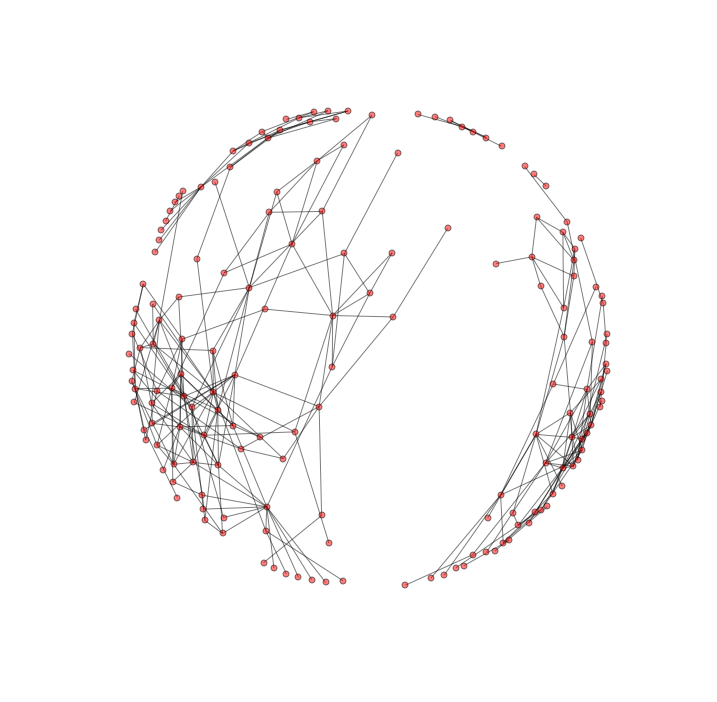

In [793]:
plt.figure(3,figsize=(12,12)) 
spring_pos_w = nx.spring_layout(only_infected)
plt.axis("off")
nx.draw_networkx(only_infected, pos = spring_pos_w, with_labels = False, node_size = 35, node_color='r',alpha=0.5,linewidths=None)

### (2.2) Visualizing the full infected social network
Here, we see the fully "infected" and representative social network. As expected, most of the nodes are green, denoting non-terrorists, while the red dots denote terrorists. We see that there are some distinct clusters of nodes, and few nodes that are completely disconnected from the rest.

In [658]:
node_color = []

for n,d in infected_network.nodes(data=True):

    # if the node has the attribute group1
    if d['infected']==1:
        node_color.append('red')
    else:
        node_color.append('green')

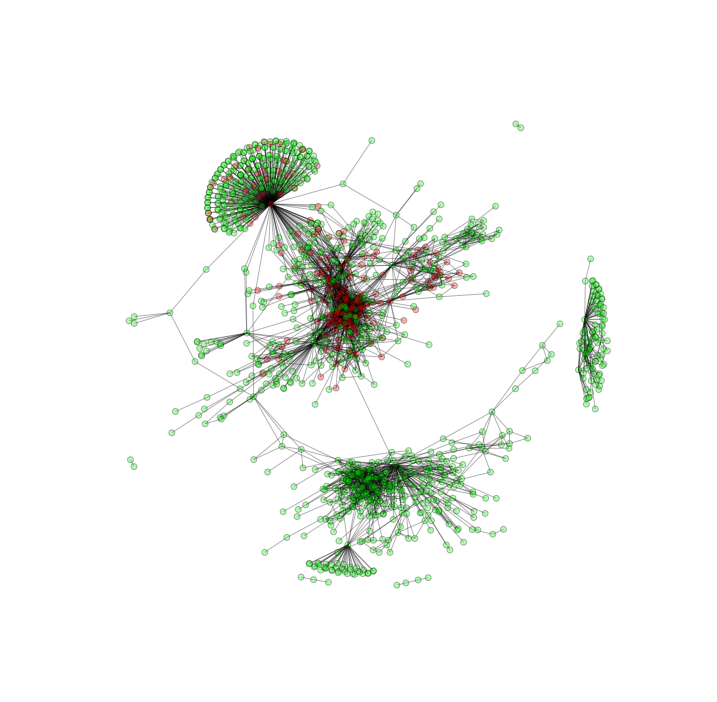

In [659]:
plt.figure(3,figsize=(12,12)) 
spring_pos_w = nx.spring_layout(infected_network)
plt.axis("off")
nx.draw_networkx(infected_network, pos = spring_pos_w, with_labels = False, node_size = 35, node_color=node_colors,alpha=0.3)


## (3) Building the Model
First, we implement:
- Statistic First Search (SFS): This means that, given one root node of a known terrorist, we expect the neighbors of the root as long as there is at least one neighboring target.
    - Scenario A: If all terrorist nodes are connected, the SFS will find all targeted nodes.
    - Scenario B: If there are unconnected clusters of terrorists, the SFS will need a new "root" node to proceed.

In [660]:
########################################
## PATH STATISTIC OF PROXIMITY
## Inputs:
##    G: Graph (social network)
##    n: node to search
##    T: List of already identified infected nodes
## Return: the # of the node's neighbors that are infected
def calc_path(G,n,T):
    target_paths = 0
    for neighbor in G.neighbors(n):
        if (neighbor in T): target_paths +=1
    return target_paths

##########################
## STATISTIC FIRST SEARCH
## Inputs:
##    G: Graph (social network)
##    t: seed node (known target/terrorist)
## Return: List of identified targets, list of investigated nodes


def SFS(G,t):
    G=infected_network
    T = {t}
    I = {t}
    N = set(infected_network.neighbors(t))

    neighbors_not_I = N.difference(I)

    # for x in np.arange(1,100):
    while (len(neighbors_not_I) > 0):
        max_paths = 0
        for n in neighbors_not_I:
            p = calc_path(G,n,T)
            if p > max_paths: selected_node = n
        I = I.union({n})
        if G.node[n]['infected']==1:
            T = T.union({n})
            N = N.union(set(G.neighbors(n)))
        neighbors_not_I = N.difference(I)
    return T,I

## Auxiliary Function
def is_infected(n,G):
        return (G.node[n]['infected'] == 1)


Next, we calculate another statistic of proximity between uninvestigated nodes and the target nodes: Common Neighbors.
This returns the number of neighbors a node has in common with any of the target nodes.

*Important to note: Common Neighbors has a sensitivity of 1 since removing/adding a node can only change the value by 1* See methodology in [1] for details.

In [695]:
###########################################
## COMMON NEIGHBORS STATISTIC OF PROXIMITY
## Inputs:
##    G: Graph (social network)
##    n: node to search
##    T: List of already identified infected nodes
## Return: the # of the common neighbors the node has with ANY of the infected nodes
## Note: See appendix C for simple demonstration

def calc_CN(G,n,T):
    common_neighbors = set()
    for target in T:
        node_neighbors = set(G.neighbors(n))
        target_neighbors = set(G.neighbors(target))
        common_neighbors_t = node_neighbors.intersection(target_neighbors)
        common_neighbors = common_neighbors.union(common_neighbors_t)
    return len(list(common_neighbors))

In [784]:
#########################
## NETWORK SEARCH
## Inputs:
##    G: Graph (social network)
##    T: List of already identified infected nodes (result of SFS, above)
##    I: List of already inspected nodes
##    sop_func: Function used for statistic of proximity ()
##    e: epsilon value
##    K: number of rounds of neighbors to check
##    noise: Differentially Private or Not or not (default=True)
## Return: Next infected node  

def searchCOM(G, T , I, sop_func, e, K, noise=True):
    CN_impact_card = 1
    CN_sensitivity = 1
    lap_arg = 2*CN_impact_card / e
    
    
    noisy_K = K + np.random.laplace(0,lap_arg)
    count = 0
    unvisited = set(G.nodes()).difference(I)


    # Go through unvisited nodes to calculate SoP using Common Neighbors
    noisy_sops = {}
    max_sop = 0
    max_sop_node = ''
    for n in unvisited:
        res = calc_CN(G,n,T) + np.random.laplace(0,4*CN_sensitivity/e)
        if res > max_sop:
            max_sop_node = n
            max_sop = res
        noisy_sops[n] = res
    
    success = 0
    
    # Pick randomly if tie for max
    while count < noisy_K:
        max_elts = []
        for k,v in noisy_sops.iteritems():
            if v==max([i for i in noisy_sops.values()]): max_elts.append(k)
        elt_choice = random.choice(max_elts)

        I = I.union({elt_choice})

        noisy_sops = {key: value for key, value in noisy_sops.items() 
                     if key is not elt_choice}
        # Investigate
        if G.node[elt_choice]['infected']==1:
            return elt_choice
        count +=1
    return -1
    
    

In [785]:
################################
## NETWORK SEARCH WITH TRAVERSAL
## Inputs:
##    G: Graph (social network)
##    s: seed node (known terrorist)
##    f: Function used for statistic of proximity ()
##    e: epsilon value
##    K: number of rounds of neighbors to check
##    N: number of new terrorist network rounds to attempt to detect
##    noise: Differentially Private or Not or not (default=True)
## Return: Set of infected nodes discovered by function
## Note: This is simply a combination of the prior models

def PTarget(G, s, f, k, e, N):
    I = {s}
    T,investigated = SFS(G,s)
    I = I.union(investigated)
    for n in np.arange(0,k):
        new_result = searchCOM(G, T, I, f, e, N)
        if new_result == -1:
            return T
        else:
            T_new,investigated = SFS(G,new_result)
            I = I.union(investigated)
            T = T.union(T_new)
    return T
    

## Running the Privacy-Protected Network Search
When we use a metric of investigating at a 10% rate (of all nodes) and examining neighbors at a 5% rate (of all nodes), we achieve a 93% accuracy on the dataset.

In [786]:
t = '529'
G=infected_network
T,I = SFS(G,t)

result_search = searchCOM(G, T , I, calc_CN, np.log(2), 5)
result_PTarget = PTarget(G,'529',calc_CN,10,np.log(2),5)

In [792]:
len_total_nodes = len(G.nodes())
len_infected_nodes = len([elt for elt in list_nodes if is_infected(elt,G)])
print "# Nodes in Network ------- TOTAL : ", len_total_nodes
print "# Nodes in Network ------- INFECTED : ", len_infected_nodes

result_PTarget = PTarget(G,'529',calc_CN,len_total_nodes*0.1,np.log(2),len_total_nodes*0.05)

print "# Nodes in Network ------- DISCOVERED : ", len(result_PTarget)


# Nodes in Network ------- TOTAL :  1177
# Nodes in Network ------- INFECTED :  299
# Nodes in Network ------- DISCOVERED :  279


# Conclusions

The implementation of the Kearns et al. model to a relateable dataset helps to frame a policy debate in a more useful way. The authors of the paper did rigorous statistical testing to fully determine the performance of their Targeted Search when taking into account different parameters of K and N in PTarget.

Further work with this facebook data would include doing these same tests as well as bringing in multiple dimensions, including the "Weight" of edges, which could be a proxy for Number of Likes between users or geographic proximity. Differential Privacy in this context helps balance the privacy cost assumptions associated with investigating people and the information costs of perturbing data.

# Appendix

## A. Independent Cascade Model Testing

First, we test the implementation of the independent cascade model with a sample dataset.
We run the model 10000 times to see the distribution of infected nodes. Since the Probability of Infection (encoded in *act_prob*) is 0.2 and the seed node is connected to two different nodes, we expect the infection to spread beyond the seed node 40% of the time.(Given two neighbors, P(disease_spread) = P(neighbor_A_infected) + P(neighbor_B_infected) = 0.2 + 0.2 = 0.4)

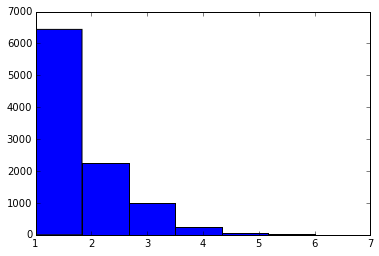

0.3558


In [112]:
DG = nx.DiGraph()
DG.add_edges_from([(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
(4,6), (5,3), (5,4), (5,6), (6,4), (6,5)], act_prob=0.2)
# spring_pos = nx.spring_layout(DG)
# nx.draw_networkx(DG, pos = spring_pos, with_labels = False, node_size = 35)


outcome_len = []
for n in np.arange(0,10000):
    H = ic.independent_cascade(DG,[6])
    outcome_len.append(len(H) - 1)
plt.hist(outcome_len,bins=6)
plt.show()
print len([elt for elt in outcome_len if elt > 1])/10000.

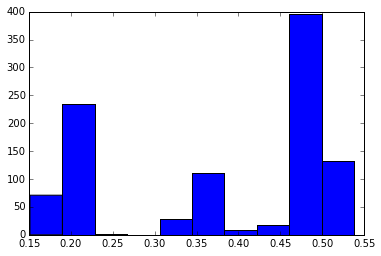

In [114]:
# Test Infection Cascading with Larger Datasets
def test_cascade(tuple_list):
    DG = nx.DiGraph()
    DG.add_edges_from(tuple_list, act_prob=0.2)
    
    rand_row = random.randint(0, len(tuple_list) - 1)
    rand_col = random.randint(0,1)
    
    try:
        my_seed = tuple_list[rand_row][rand_col]
    except IndexError:
        print len(tuple_list),rand_row,rand_col
        
    outcome_len = []
    n_trials = 1000
    for n in np.arange(0,n_trials):
        H = ic.independent_cascade(DG,[my_seed])
        outcome_len.append(len(H) - 1)
    prop_over1 = len([elt for elt in outcome_len if elt > 1])/(n_trials * 1.)
    return prop_over1

prop_list = []
for n in np.arange(0,1000):
#     mylist = [ ( random.randint(0, 50), random.randint(0, 50) ) for k in range(150) ]
#     myList = (list(set(mylist)))
    myList = [(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
(4,6), (5,3), (5,4), (5,6), (6,4), (6,5)]
    prop_list.append(test_cascade(myList))

plt.hist(prop_list)
plt.show()
 

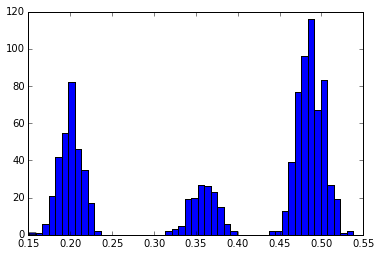

In [116]:
plt.hist(prop_list,bins=50)
plt.show()

## B. Data Sampling & Preparation

In [5]:
## Full Facebook Dataset
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_fb)
spring_pos = nx.spring_layout(G_fb)
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [5]:
## Full DBLP Dataset -- Subset first
df = np.loadtxt("com-dblp.ungraph.txt")
idx = random.sample(xrange(0,df.shape[0]),10000)
idx = (list(set(idx)))
idx.sort()
df_rand10000 = df[idx]
np.savetxt("dblp_rand10000.txt",df_rand10000,fmt="%d")

In [6]:
df_first10000= df[0:10000]
np.savetxt("dblp_first10000.txt",df_first10000,fmt="%d")

Name: 
Type: Graph
Number of nodes: 8655
Number of edges: 10000
Average degree:   2.3108


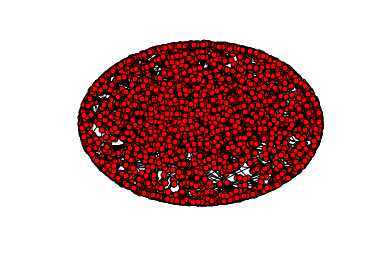

In [7]:
G_dblp_first = nx.read_edgelist("dblp_first10000.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_dblp_first)
spring_pos = nx.spring_layout(G_dblp_first)
plt.axis("off")
nx.draw_networkx(G_dblp_first, pos = spring_pos, with_labels = False, node_size = 35)

Name: 
Type: Graph
Number of nodes: 18373
Number of edges: 10000
Average degree:   1.0886


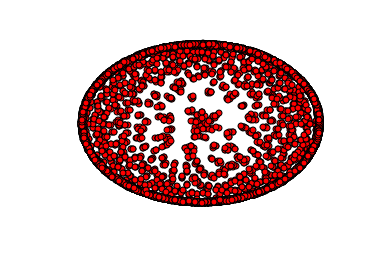

In [8]:
G_dblp_rand = nx.read_edgelist("dblp_rand10000.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_dblp_rand)
spring_pos = nx.spring_layout(G_dblp_rand)
plt.axis("off")
nx.draw_networkx(G_dblp_rand, pos = spring_pos, with_labels = False, node_size = 35)


In [17]:
## Add weights to dataset function

def add_weights_and_save(sample,df,filename):
    if len(sample) != df.shape[0]:
        print "ERROR: DF andSamples must be same length"
        return -1
    else:
        df_weighted = np.zeros((len(sample),3))
        df_weighted[:,:-1] = df
        df_weighted[:,-1] = sample
        np.savetxt(filename,df_weighted,fmt="%d")
        return 1
            

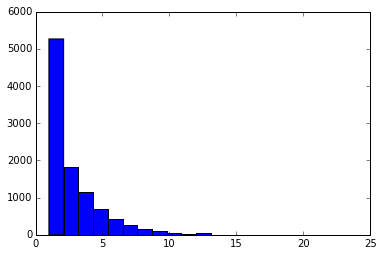

In [10]:
## Choose Exponential Distribution for how to distribute weights

distribution = scipy.stats.expon(loc=1,scale=2)
sample = distribution.rvs(size=10000)
sample = [np.round(elt) for elt in sample]
plt.hist(sample,bins=20)
plt.show()

Name: 
Type: Graph
Number of nodes: 2002
Number of edges: 10000
Average degree:   9.9900


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


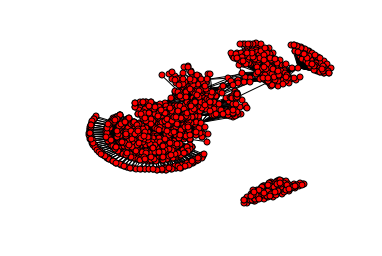

In [7]:
# Weighted 
G_fb_w = nx.read_weighted_edgelist("facebook_combined_first10000w.txt")
print nx.info(G_fb_w)
spring_pos_w = nx.spring_layout(G_fb_w)
plt.axis("off")
nx.draw_networkx(G_fb_w, pos = spring_pos_w, with_labels = False, node_size = 35)


In [380]:
## Data Separation -- we take relationships that have 
G_fb_w = nx.read_weighted_edgelist("facebook_combined_first10000w.txt")
df_over_n = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] >4 ]
df_under_n = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] <= 4]

W > n: 1772
W <= n 8228


# C. Showing Efficacy of Common Neighbor Statistic of Proximity

RESULT:
7 has 2 neighbors in common with the target nodes  set([1, 3])


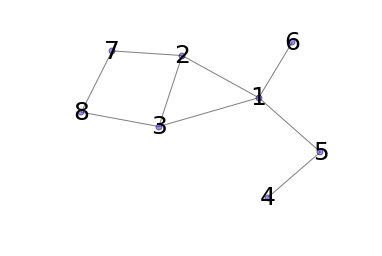

In [798]:
newG = nx.Graph()
newG.add_edges_from([(1,2),(2,3),(3,1),(4,5),(1,5),(1,6),(7,2),(7,8),(8,3)])
spring_pos_w = nx.spring_layout(newG)
plt.axis("off")
nx.draw_networkx(newG, pos = spring_pos_w, with_labels = True, node_size = 35, node_color="#3f24ff",alpha=0.5,
                 linewidths=None,font_size=25)
targets = {1,3}
newG
n = 7
print "RESULT:"
print n,"has",calc_CN(newG,n,targets),"neighbors in common with the target nodes ",targets